<a href="https://www.kaggle.com/code/sahilr05/energy-consumption-xgboost?scriptVersionId=107070541" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
data  = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
data = data.set_index("Datetime")

In [5]:
data.index =pd.to_datetime(data.index)

<AxesSubplot:title={'center':'PJME_hourly'}, xlabel='Datetime'>

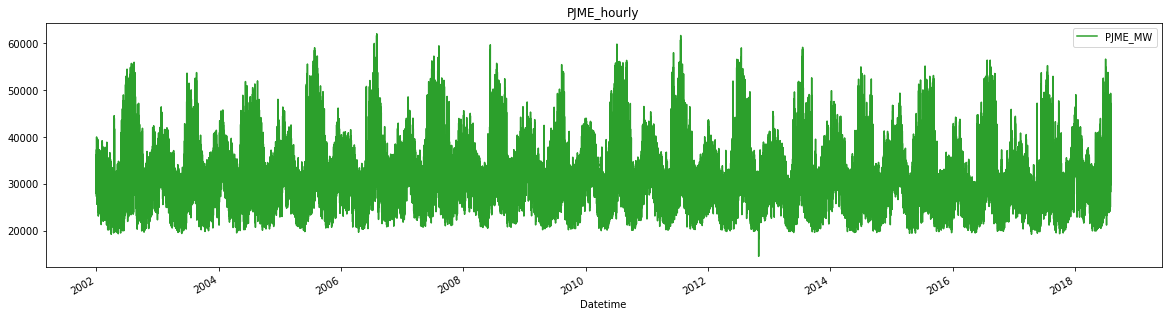

In [6]:
data.plot(figsize=(20,5),color=color_pal[2],title="PJME_hourly")

Split Data

In [7]:
train = data.iloc[data.index < "01-01-2015"]
test = data.iloc[data.index >= "01-01-2015"]

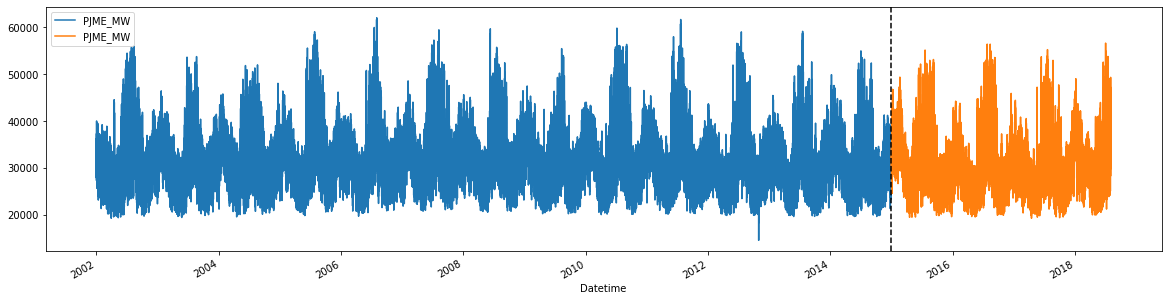

In [8]:
fig,ax = plt.subplots(figsize=(20,5))
train.plot(ax=ax)
test.plot(ax=ax)
ax.axvline("01-01-2015",color="black",ls='--')

<AxesSubplot:title={'center':'Week Data'}, xlabel='Datetime'>

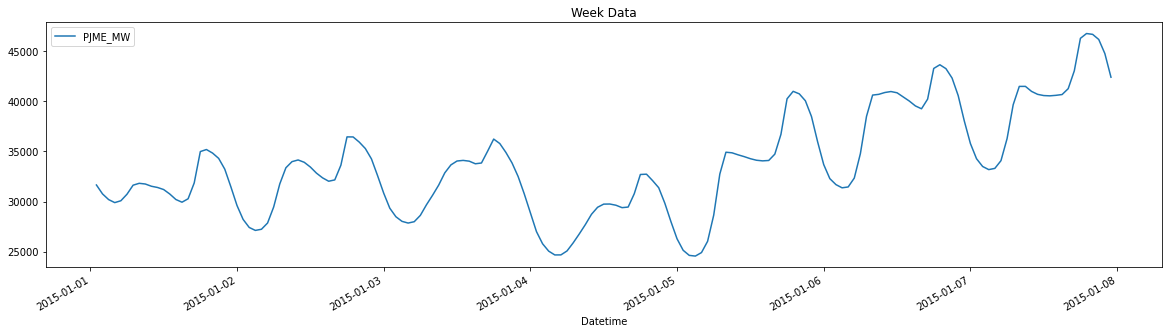

In [9]:
data.iloc[(data.index > "01-01-2015") &(data.index < "01-08-2015")].plot(figsize=(20,5),title="Week Data")

In [10]:
def ceate_fet(data):
    data = data.copy()
    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    data["quarter"] = data.index.quarter
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    return data

In [11]:
data = ceate_fet(data)

Text(0.5, 1.0, 'Hourly use')

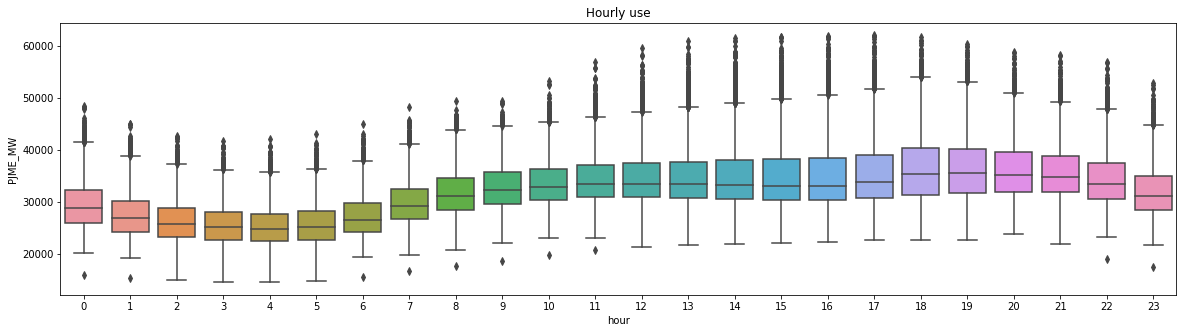

In [12]:
plt.figure(figsize=(20,5))
sns.boxplot(data=data,x="hour",y="PJME_MW")
plt.title("Hourly use")

Text(0.5, 1.0, 'monthly use')

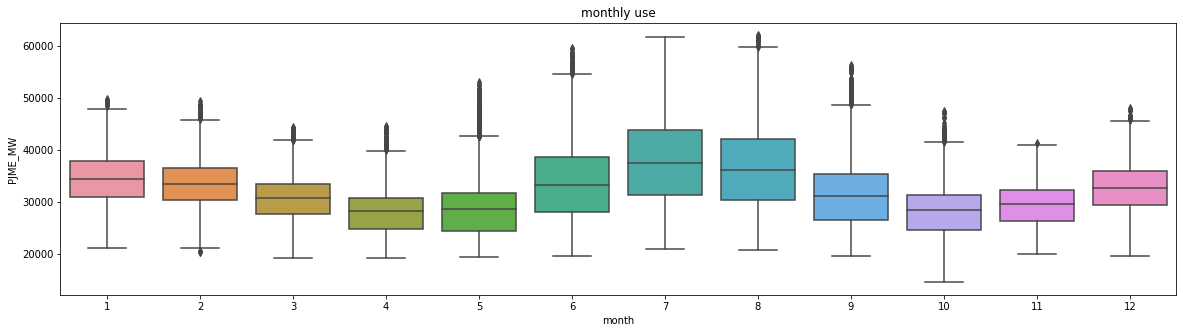

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(data=data,x="month",y="PJME_MW")
plt.title("monthly use")

Create Mode

In [14]:
train = ceate_fet(train)
test = ceate_fet(test)
x_train = train.drop(["PJME_MW"],axis=1)
y_train = train["PJME_MW"]

x_test = test.drop(["PJME_MW"],axis=1)
y_test = test["PJME_MW"]

In [15]:
model = xgb.XGBRegressor(n_estimators=1000,early_stopping_round=50,learning_rate=0.01)
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[05:35:49] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[500]	validation_0-rmse:2699.48868	validation_1-rmse:3756.65302
[600]	validation_0-rmse:2601.12457	validation_1-rmse:3806.77964
[700]	validation_0-rmse:2516.64000	validation_1-rmse:3845.80090
[800]	validation_0-rmse:2459.07473	validation_1-rmse:3873.51681
[900]	validation_0-rmse:2422.21030	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_round=50, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [16]:
test["prediction"]  =model.predict(x_test)

In [17]:
df = data.merge(test[["prediction"]],how="left",left_index=True,right_index=True)

<AxesSubplot:xlabel='Datetime'>

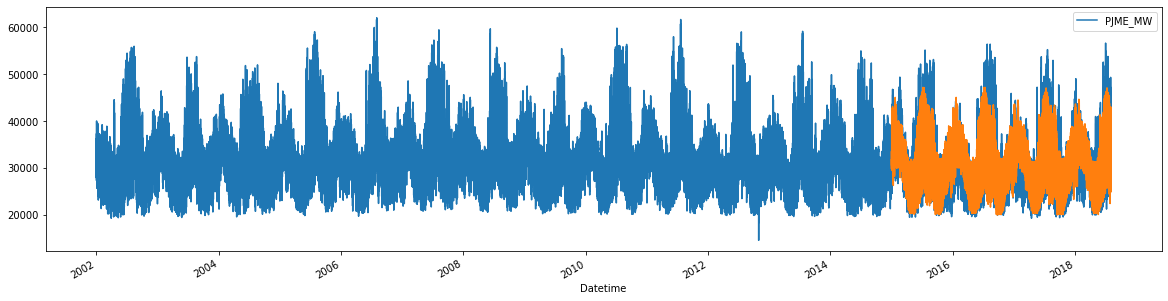

In [18]:
df[["PJME_MW"]].plot(figsize=(20,5))
df["prediction"].plot(figsize=(20,5))

In [19]:
np.sqrt(mean_squared_error(test["PJME_MW"],test["prediction"]))

3940.7474234576725